In [2]:
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')

from parse_density_files import CUBE
import alchemy_tools2 as at

import numpy as np
from matplotlib import pyplot as plt

import utils_qm as uqm

from ase.units import Bohr

In [38]:
def get_alchpot(grid, h_matrix, nuc_pos, rho):
    distances = at.distance_MIC2(nuc_pos, grid, h_matrix)
    return(-rho/distances)

def get_plane_idx(coord, grid3d):
    plane_idx = np.where(np.isclose(grid3d, coord))[0][0]
    return(plane_idx)

def get_plane(atoms, config, dens):

    atom_index = config['atom_index'] # 2, 4 should be ok as well for bond strech
    coord_index = config['coord_index'] # z-coordinate
    coord = atoms[atom_index, coord_index] # z-position of molecule
    grid = np.load(config['grid'])
    plane_idx = get_plane_idx(coord, grid[0]) # xy-plane in which molecule
    
    dens_plane = dens[:,:,plane_idx]
    atom_coordinates = atoms[config['atoms']][:,1:3]
    
    return(atom_coordinates, dens_plane)
    
def read_config(config_file):
    config = dict()
    with open(config_file, 'r') as f:
        for line in f:
            parameter, value = line.split(':')
            if parameter == 'grid':
                config[parameter] = value.strip('\n').strip()
            elif parameter == 'hmatrix':
                config[parameter] = value.strip('\n').strip()
            elif parameter == 'atom_index':
                config[parameter] = int(value.strip('\n'))
            elif parameter == 'coord_index':
                config[parameter] = int(value.strip('\n'))
            elif parameter == 'atoms':
                indices = value.strip('\n')
                indices = [int(i) for i in indices.split(',')]
                config[parameter] = indices
    return(config)

In [81]:
# load stuff
path_config = '/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/butanol/config.txt'
config = read_config(path_config)
path_results = '/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/bond_stretch/butanol/dist_0.0/results.dict'
results = uqm.load_obj(path_results)

# rho at lambda = 1
atom_coordinates, dens_plane = get_plane( results['nuclei'], config, results['densities'][-1])

# rho tilde
rho_tilde = np.trapz(results['densities'], results['lam_vals'], axis=0)
atom_coordinates, rho_tilde_plane = get_plane(results['nuclei'], config, rho_tilde)

# alchemical potential
grid = np.load(config['grid'])
pos = results['nuclei'][:,1:]
hmatrix = np.load(config['hmatrix'])

alchpot_planes = []
for i in config['atoms']: # the atoms for which the alchpot is calculated (heavy atoms in the plane)
    alchpot = get_alchpot(grid, hmatrix, results['nuclei'][i,1:], rho_tilde)
    atom_coordinates, alchpot_plane = get_plane(results['nuclei'], config, alchpot)
    alchpot_planes.append([results['nuclei'][i,1:3], atom_coordinates, alchpot_plane])


(9.0, 12.0)

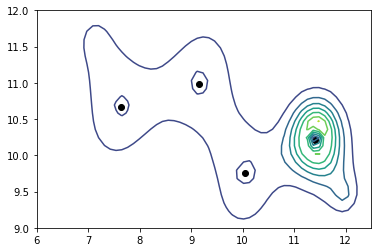

In [50]:
# plot rho at lambda = 1
x = np.linspace(0, 18.8, 168)
y = np.linspace(0, 18.8, 168)
plt.contour(x,y, dens_plane)
plt.scatter(atom_coordinates[:,1]*Bohr, atom_coordinates[:,0]*Bohr, color='black')

# plt.contour(x,y, rho_tilde_plane)
# plt.scatter(atom_coordinates[:,1]*Bohr, atom_coordinates[:,0]*Bohr, color='black')

plt.xlim([6.0, 12.5])
plt.ylim([9.0, 12.0])

(9.0, 12.0)

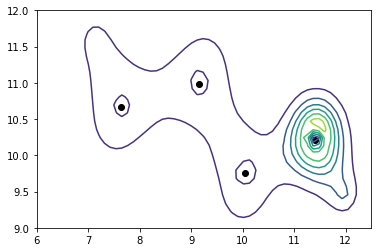

In [19]:
# plot rho tilde
x = np.linspace(0, 18.8, 168)
y = np.linspace(0, 18.8, 168)
plt.contour(x,y, rho_tilde_plane)
plt.scatter(atom_coordinates[:,1]*Bohr, atom_coordinates[:,0]*Bohr, color='black')

plt.xlim([6.0, 12.5])
plt.ylim([9.0, 12.0])

(9.0, 12.0)

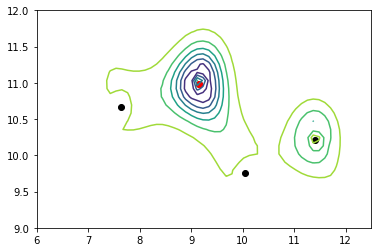

In [78]:
# plot of alchemical potentials
i=1
x = np.linspace(0, 18.8, 168)
y = np.linspace(0, 18.8, 168)
plt.contour(x,y, alchpot_planes[i][2])
plt.scatter(atom_coordinates[:,1]*Bohr, atom_coordinates[:,0]*Bohr, color='black')
plt.scatter([alchpot_planes[i][0][1]*Bohr], [alchpot_planes[i][0][0]*Bohr], color='red')
plt.xlim([6.0, 12.5])
plt.ylim([9.0, 12.0])

In [ ]:
from ase import Atoms
from ase.units import Bohr

from scipy.spatial.transform import Rotation

In [ ]:
# make plane if not

In [ ]:
def get_plane(molecule, p1, p2, s):
    """
    rotates molecule such that the plane formed by the atoms at positions p1, p2, s is orthogonal to n_plane
    """
    v1 = molecule.get_positions()[s] - molecule.get_positions()[p1]
    v2 = molecule.get_positions()[s] - molecule.get_positions()[p2]
    n = np.cross(v1, v2)/np.linalg.norm(np.cross(v1, v2))
    return(n)

In [ ]:
dens_file = CUBE('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/angles/butanol/ang_0.0/cube-files/ve_32.cube')
dens_file2 = CUBE('/home/misa/projects/atomic-energies/data/ueg_reference/amons/geometry/angles/butanol/ang_50.0/cube-files/ve_32.cube')

In [ ]:
mol0 = Atoms(numbers=dens_file.atoms[:,0], positions=dens_file.atoms[:,1:4])
mol50 = Atoms(numbers=dens_file2.atoms[:,0], positions=dens_file2.atoms[:,1:4])

n = get_plane(mol50, 1,4,2)
z = np.array([0,0,1])

In [ ]:
m = Rotation.align_vectors(n.reshape(1,3),z.reshape(1,3))

In [ ]:
gridli = []
for i in np.linspace(-5, 7.5, 26):
    for j in np.linspace(-2.5, 5, 16):
        gridli.append([i,j,0.0])

In [ ]:
transformed_grid = []
shift = mol50.get_positions()[2]
for p in gridli:
    transformed_grid.append(m[0].as_matrix()@p+shift)
transformed_grid = np.array(transformed_grid)

In [ ]:
xl, xh = np.amin(dens_file.atoms[:5,1]), np.amax(dens_file.atoms[:5,1])
yl, yh = np.amin(dens_file.atoms[:5,2]), np.amax(dens_file.atoms[:5,2])
zl, zh = np.amin(dens_file.atoms[:5,3]), np.amax(dens_file.atoms[:5,3])

In [ ]:
print(xl, xh)
print(yl, yh)
print(zl, zh)

In [ ]:
index = []
grid= dens_file2.get_grid()
for point in transformed_grid:
    dist = np.zeros(len(grid[0].flatten()))
    for p, g in zip(point, dens_file2.get_grid()):
        dist[:] += (p - g.flatten())**2
    index.append(np.where(dist==np.amin(dist)))

In [ ]:
index_clean = []
for i in index:
    index_clean.append(i[0][0])

In [ ]:
index_reshaped = np.arange(len(grid[0].flatten()))
index_reshaped = index_reshaped.reshape(168,168,168)

In [ ]:
density_transformed = []
for i in range(len(index_clean)):
    density_transformed.append(dens_file.data_scaled[np.where(index_clean[i]==index_reshaped)][0])

In [ ]:
density_transformed = np.array(density_transformed).reshape(26,16)

In [ ]:
plt.contour(density_transformed.T)

In [ ]:
density_transformed.T.shape

In [ ]:
density_transformed = []
for i in range(len(index_clean)):
    density_transformed.append(dens_file2.data_scaled[np.where(index_clean[i]==index_reshaped)][0])
density_transformed = np.array(density_transformed).reshape(26,16)

In [ ]:
plt.contour(density_transformed.T)